# 3D Semantic Map Building
In this notebook, we load the RGB-D images and poses generated from `Generate_trajectory.ipynb`, and build a 3D map

In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import open3d as o3d

from src.features.mapping import SemanticMap3DBuilder
from src.config import default_map_builder_cfg, default_sim_cfg
from src.utils import category_mapping
import pathlib
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
if pathlib.PurePath(os.getcwd()).name == 'notebooks':
    os.chdir('..')

In [3]:
TRAJECTORY = "00006-HkseAnWCgqk"
DEPTH_MAP_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/D"
RGB_IMAGE_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/RGB"
POSITIONS_FILE = f"./data/interim/trajectories/train/{TRAJECTORY}/positions.npy"
ROTATIONS_FILE = f"./data/interim/trajectories/train/{TRAJECTORY}/rotations.npy"
SEMANTIC_MAP_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/Semantic"
SEMANTIC_INFO_FILE = "./data/raw/train/scene_datasets/hm3d/train/00006-HkseAnWCgqk/HkseAnWCgqk.semantic.txt"

In [4]:
scene_to_reseal_mapping = category_mapping.get_scene_index_to_reseal_index_map_vectorized(SEMANTIC_INFO_FILE)
scene_to_matterport_mapping = np.vectorize(category_mapping.get_scene_index_to_matterport_index_map(SEMANTIC_INFO_FILE).get)

Create map builder

In [8]:
sim_cfg = default_sim_cfg()
map_builder_cfg = default_map_builder_cfg()
map_builder_cfg.NUM_SEMANTIC_CLASSES = 6
map_builder_cfg.RESOLUTION = 0.05
map_builder_cfg.MAP_SIZE = [3, 2, 3]
map_builder = SemanticMap3DBuilder(map_builder_cfg, sim_cfg)


In [9]:
def get_semantic_map(saved_semantics):
    semantic_map_matterport_indices = scene_to_reseal_mapping(saved_semantics)
    semantic_map = np.zeros((saved_semantics.size, map_builder_cfg.NUM_SEMANTIC_CLASSES + 1))
    semantic_map[np.arange(semantic_map_matterport_indices.size), semantic_map_matterport_indices.flatten()] = 1
    semantic_map = semantic_map.reshape(saved_semantics.shape + (map_builder_cfg.NUM_SEMANTIC_CLASSES + 1,))[:,:,1:]
    return semantic_map

Load poses, rgb images and depth images. Create semantic map, with RGB images as a placeholder for semantic labels

In [10]:
rotations = np.load(ROTATIONS_FILE).view(dtype=np.quaternion)
positions = np.load(POSITIONS_FILE)

map_builder.clear()
for i in tqdm(range(400)):
    depth_map = np.load(f"{DEPTH_MAP_DIR}/{i}.npy")
    saved_semantics = np.load(f"{SEMANTIC_MAP_DIR}/{i}.npy")
    semantic_map = get_semantic_map(saved_semantics)
    pose = (positions[i], rotations[i])
    map_builder.update_point_cloud(semantic_map, depth_map, pose)
    #map_builder.update_point_cloud(semantic_map, depth_map, pose)

100%|██████████| 400/400 [00:39<00:00, 10.07it/s]


In [14]:
point_cloud = np.asarray(map_builder.point_cloud.points)
point_cloud_semantic_labels = map_builder._point_cloud_semantic_labels

Get point cloud and visualize

In [16]:
point_cloud_categorical = (np.argmax(point_cloud_semantic_labels, axis=-1) + 
                           np.sum(point_cloud_semantic_labels, axis=-1))

In [18]:
from matplotlib.colors import to_rgb
from src.config import default_data_paths_cfg
import csv

data_paths_cfg = default_data_paths_cfg()

reseal_index_to_color = {}
with open(data_paths_cfg.RESEAL_MAPPING_PATH, encoding='utf8') as csvfile:
    reader = csv.reader(csvfile, delimiter = '\t')
    next(iter(reader))
    for row in reader:
        reseal_index_to_color[int(row[0])] = np.array(to_rgb(f"#{row[2]}"))

color_converter = np.vectorize(reseal_index_to_color.get, signature='()->(n)')
point_cloud_rgb = np.dstack([point_cloud_categorical]*3)[0]
point_cloud_rgb[point_cloud_categorical > 0] = color_converter(point_cloud_categorical[point_cloud_categorical > 0])

In [19]:
point_cloud_o3d = o3d.utility.Vector3dVector(point_cloud[point_cloud_categorical > 0])
pcd = o3d.geometry.PointCloud(point_cloud_o3d)
colour = point_cloud_rgb[point_cloud_categorical > 0]
pcd.colors = o3d.utility.Vector3dVector(colour)
o3d.visualization.draw_geometries([pcd])

Get 3D Semantci map (i.e. Voxel grid)

In [20]:
coords = np.asarray(point_cloud)
semantic_map = point_cloud_semantic_labels

In [21]:
print(np.min(coords, axis=0))
print(np.max(coords, axis=0))

[-8.7294759  -0.91625865 -5.29385401]
[3.34878407 4.52224405 5.24345589]


In [22]:
middle = (np.max(coords, axis=0) + np.min(coords, axis=0)) / 2

position = (np.max(coords, axis=0) + np.min(coords, axis=0)) / 2

min_position = np.min(coords, axis=0)
max_position = np.max(coords, axis=0)

shift = min_position % map_builder._resolution
min_position = min_position - shift
max_position = max_position - shift

In [17]:
x,y,z = position = (-3, 1.5, 0)

min_position = position - map_builder._map_size / 2
max_position = position + map_builder._map_size / 2

shift = min_position % map_builder._resolution
min_position = min_position - shift
max_position = max_position - shift

In [23]:
from src.utils.geometric_transformations import coordinates_to_grid_indices
grid_index_of_min_position_relative_to_origin = coordinates_to_grid_indices(min_position, [0,0,0], map_builder._resolution)
grid_index_of_origin_relative_to_min_position = - grid_index_of_min_position_relative_to_origin

In [24]:
relevant_points = np.where(np.all(np.logical_and(coords > min_position, coords < max_position), axis=-1))[0]

In [25]:
relevant_coords = coords[relevant_points]
relevant_semantics = semantic_map[relevant_points]

In [26]:
grid_indices = coordinates_to_grid_indices(relevant_coords, grid_index_of_origin_relative_to_min_position, map_builder._resolution)

In [27]:
grid_indices.shape

(25558334, 3)

In [28]:
semantic_3d_map_shape = (*np.round((max_position - min_position) / map_builder._resolution).astype(int) + 1, map_builder._num_semantic_classes+1)

In [29]:
grid = np.zeros(semantic_3d_map_shape)

In [30]:
grid[grid_indices[:,0], grid_indices[:,1], grid_indices[:,2], 0] = 1

In [31]:
interesting_points = relevant_semantics.sum(axis=-1) > 0
pruned_semantics = relevant_semantics[interesting_points]
pruned_grid_indices = grid_indices[interesting_points]

In [32]:
for grid_index, semantic in zip(pruned_grid_indices, pruned_semantics):
    grid[grid_index[0], grid_index[1], grid_index[2], 1:] = (
        np.max(np.vstack([grid[grid_index[0], grid_index[1], grid_index[2], 1:], semantic]), axis=0))

In [33]:
reseal_category = (grid[:,:,:,1:].argmax(axis=-1) + grid[:,:,:,1:].sum(axis=-1))
colour = color_converter(reseal_category)

In [34]:
grid[:,:,:,0].shape

(243, 110, 212)

In [35]:
uninteresting_voxels = grid[:,:,:,1:].sum(axis=-1) == 0

In [36]:
grid_for_plotting = grid.copy()
grid_for_plotting[uninteresting_voxels,:]=0

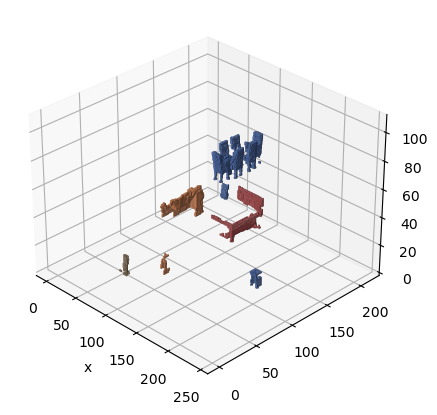

In [37]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

grid_T = np.transpose(grid_for_plotting, (0,2,1,3))
colour_T = np.transpose(colour, (0,2,1,3))


# Plot 3d voxel grid
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111, projection='3d')
ax1.voxels(grid_T[:,:,:,0], facecolors=colour_T)
ax1.set_xlabel('x')
ax1.view_init(azim=-45)
plt.show()


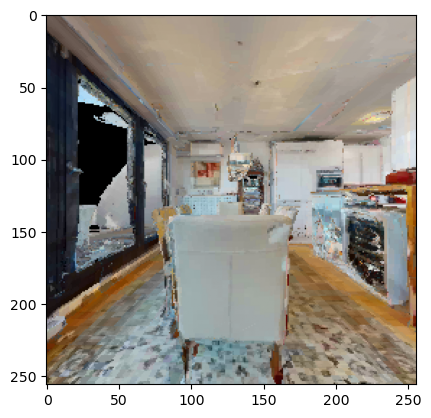

In [72]:
rgb_image = cv2.imread(f"{RGB_IMAGE_DIR}/{300}.png")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
rgb_image = rgb_image / 255
plt.imshow(rgb_image)

In [119]:
from src.features.perception import raytrace_3d, propagate_labels, get_ray_directions_world_coords
from src.utils.geometric_transformations import coordinates_to_grid_indices
from yacs.config import CfgNode
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import quaternion

def raytracing3d_map_visualisation_sensor_cfg() -> CfgNode:
    sensor_cfg = CfgNode()
    sensor_cfg.WIDTH = 256 #px
    sensor_cfg.HEIGHT = 256 #px
    sensor_cfg.HFOV = 90 #deg
    sensor_cfg.SENSOR_HEIGHT = 0.88 #m
    return sensor_cfg

def raytracing3d_map_visualisation_cfg():
    cfg = CfgNode()
    cfg.RESOLUTION = 0.05
    cfg.SENSOR_CFG = raytracing3d_map_visualisation_sensor_cfg()
    return cfg

sim_cfg = raytracing3d_map_visualisation_cfg()
sensor_position = tuple(positions[301])
rotation_float = np.random.rand(3)
rotation_float = [0,0,1]
#rotation_float[1] = rotation_float[1]*0.1
rotation_float = rotation_float / np.linalg.norm(rotation_float)
sensor_rotation = np.quaternion(rotation_float[0], rotation_float[1], rotation_float[2], 0)
rotation = quaternion.as_float_array(rotations[301])
sensor_rotation = np.quaternion(rotation[2], rotation[1], rotation[0], 0)
grid_index_of_origin = grid_index_of_origin_relative_to_min_position

In [120]:
semantic_map_2d = propagate_labels(sensor_rotation, sensor_position, grid, grid_index_of_origin, sim_cfg)

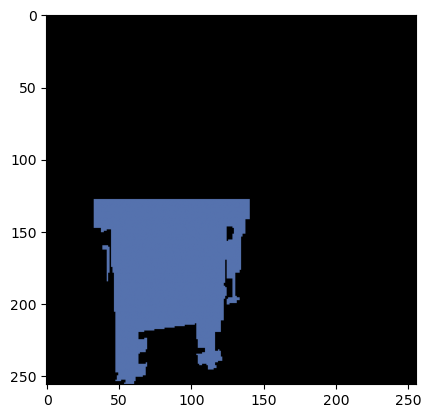

In [121]:
semantic_map_categorical = (np.argmax(semantic_map_2d, axis=-1) + 
                            np.sum(semantic_map_2d, axis=-1))

plt.imshow(color_converter(semantic_map_categorical))

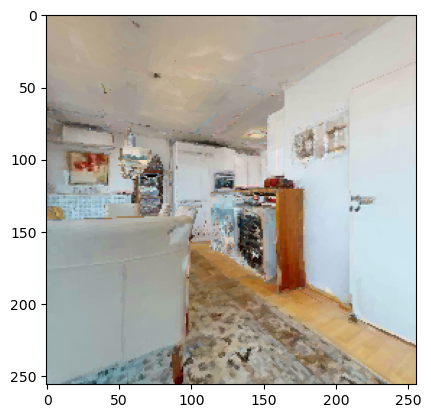

In [122]:
rgb_image = cv2.imread(f"{RGB_IMAGE_DIR}/{301}.png")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
rgb_image = rgb_image / 255
plt.imshow(rgb_image)